<a href="https://colab.research.google.com/github/comojin1994/Deep_Learning_Study/blob/master/3step_lecture/improve_lack_of_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from imblearn.over_sampling import BorderlineSMOTE
%matplotlib inline
tf.__version__

TensorFlow 2.x selected.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


'2.1.0'

### Hyperparameter

In [0]:
EPOCHS = 100

### Model

In [0]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(1024, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x, training=False, mask=None):
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

### Load Data(imbalance)

In [4]:
cifar10 = tf.keras.datasets.cifar10 # 32x32x3

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# TODO: 학습 데이터를 Imbalanced small dataset으로 변형하기
x_train_small = list()
y_train_small = list()
for x, y in zip(x_train, y_train):
    if (y == 0 and random.randint(0, 100) < 10) or y == 1:
        x_train_small.append(x[:])
        y_train_small.append(y)

x_test_small = list()
y_test_small = list()
for x, y in zip(x_test, y_test):
    if y == 0 or y == 1:
        x_test_small.append(x[:])
        y_test_small.append(y)

x_train = np.stack(x_train_small, axis=0)
y_train = np.stack(y_train_small, axis=0)

x_test = np.stack(x_test_small, axis=0)
y_test = np.stack(y_test_small, axis=0)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32).prefetch(2048)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(2048)

170500096/170498071 [==============================] - 4s 0us/step


### Training with imbalance data

In [0]:
model = MyModel()

loss_object = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam()
metrics = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]
model.compile(optimizer=optimizer, loss=loss_object, metrics=metrics)

In [8]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=test_ds)

Train for 172 steps, validate for 63 steps
Epoch 1/100
172/172 [==============================] - 3s 19ms/step - loss: 0.4653 - accuracy: 0.9032 - precision: 0.9187 - recall: 0.9804 - val_loss: 0.7737 - val_accuracy: 0.6030 - val_precision: 0.5582 - val_recall: 0.9880
Epoch 2/100
172/172 [==============================] - 1s 6ms/step - loss: 0.2531 - accuracy: 0.9152 - precision: 0.9263 - recall: 0.9852 - val_loss: 0.6172 - val_accuracy: 0.7035 - val_precision: 0.6326 - val_recall: 0.9710
Epoch 3/100
172/172 [==============================] - 1s 6ms/step - loss: 0.2302 - accuracy: 0.9205 - precision: 0.9323 - recall: 0.9840 - val_loss: 0.7496 - val_accuracy: 0.6355 - val_precision: 0.5796 - val_recall: 0.9870
Epoch 4/100
172/172 [==============================] - 1s 6ms/step - loss: 0.2207 - accuracy: 0.9209 - precision: 0.9345 - recall: 0.9818 - val_loss: 0.7180 - val_accuracy: 0.6605 - val_precision: 0.5967 - val_recall: 0.9900
Epoch 5/100
172/172 [==============================] - 1

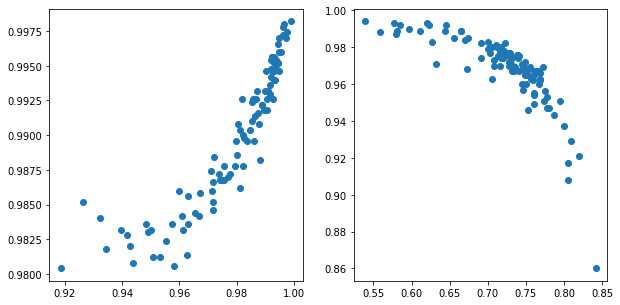

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(history.history['precision'], history.history['recall'])

plt.subplot(122)
plt.scatter(history.history['val_precision'], history.history['val_recall'])
plt.show()

### BorderlineSMOTE

In [18]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])).astype(np.float32)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])).astype(np.float32)

smote = BorderlineSMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32).prefetch(2048)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(2048)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

In [0]:
model = MyModel()
loss_object = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam()
metrics = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]
model.compile(optimizer=optimizer, loss=loss_object, metrics=metrics)

In [20]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=test_ds)

Train for 313 steps, validate for 63 steps
Epoch 1/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6332 - accuracy: 0.7343 - precision: 0.7495 - recall: 0.7038 - val_loss: 0.4618 - val_accuracy: 0.7875 - val_precision: 0.7762 - val_recall: 0.8080
Epoch 2/100
313/313 [==============================] - 2s 5ms/step - loss: 0.3744 - accuracy: 0.8446 - precision: 0.8782 - recall: 0.8002 - val_loss: 0.4066 - val_accuracy: 0.8230 - val_precision: 0.8094 - val_recall: 0.8450
Epoch 3/100
313/313 [==============================] - 2s 5ms/step - loss: 0.3185 - accuracy: 0.8722 - precision: 0.8985 - recall: 0.8392 - val_loss: 0.9271 - val_accuracy: 0.6415 - val_precision: 0.5853 - val_recall: 0.9710
Epoch 4/100
313/313 [==============================] - 2s 5ms/step - loss: 0.2524 - accuracy: 0.9048 - precision: 0.9343 - recall: 0.8708 - val_loss: 0.5595 - val_accuracy: 0.7875 - val_precision: 0.7203 - val_recall: 0.9400
Epoch 5/100
313/313 [==============================] - 2s